In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [110]:
def clean_and_load(path):
    df=pd.read_csv(path)
    df=df.rename(columns={'Amount.Requested':'Amount', 'FICO.Score':'Fico'})
    return df

def binarize(df, y, thresh):
    df['Success']=[int(b) for b in (df[y]<thresh).values]
    return df

def model(indvars, df):
    model=sm.Logit.from_formula('Success ~ %s' %(' + '.join(indvars)), df)
    return model.fit()

def prob(result, inputdict):
    ymxb=result.params['Intercept']
    for key in inputdict:
        ymxb+=result.params[key]*inputdict[key]
    return 1/(1 + math.e**(-1*ymxb))

def pred(prob, cutoff):
    if prob>=cutoff:
        print "Prediction: Accepted"
    else:
        print "Prediction: Rejected"

In [108]:
%%writefile scripts/logistic_regression.py

import statsmodels.api as sm
import pandas as pd
import math

def clean_and_load(path):
    df=pd.read_csv(path)
    df=df.rename(columns={'Amount.Requested':'Amount', 'FICO.Score':'Fico'})
    return df

def binarize(df, y, thresh):
    df['Success']=[int(b) for b in (df[y]<thresh).values]
    return df

def model(indvars, df):
    model=sm.Logit.from_formula('Success ~ %s' %(' + '.join(indvars)), df)
    return model.fit()

def prob(result, inputdict):
    ymxb=result.params['Intercept']
    for key in inputdict:
        ymxb+=result.params[key]*inputdict[key]
    return 1/(1 + math.e**(-1*ymxb))

def pred(prob, cutoff):
    if prob>=cutoff:
        print "Prediction: Accepted"
    else:
        print "Prediction: Rejected"

if __name__=='__main__':
    import sys
    from optparse import OptionParser
    parser = OptionParser()
    parser.add_option("-t", "--thresh", type="float")
    parser.add_option("-p", "--pcutoff", type="float")
    parser.add_option("-a", "--amount", type="float")
    parser.add_option("-f", "--fico", type="float")

    (options, args) = parser.parse_args()
    if options.thresh is None:
        options.thresh=12
    if options.pcutoff is None:
        options.pcutoff=.70
    if options.amount is None:
        options.amount=range(1000,50000,5000)
    else:
        options.amount=[options.amount]
    if options.fico is None:
        options.fico=range(600,850,50)
    else:
        options.fico=[options.fico]    
    df=clean_and_load('loansData_clean.csv')
    df=binarize(df, 'Interest.Rate', options.thresh)
    result=model(['Amount', 'Fico'], df)
    for amount in options.amount:
        for score in options.fico:
            p=prob(result, {'Amount':amount, 'Fico':score})
            print "probability of getting a %.2f$ loan with < %.1f%% interest and a Fico Score of %.0f  : %.3f" %(amount, options.thresh, score, p)
            pred(p, options.pcutoff)
            print ""
    

Overwriting scripts/logistic_regression.py


Optimization terminated successfully.
         Current function value: 0.319503
         Iterations 8


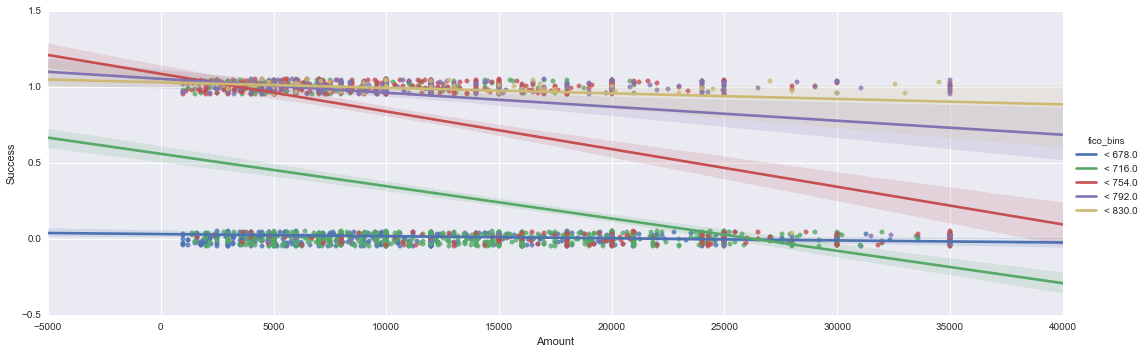

In [113]:
import seaborn as sns
import scipy.stats
df=clean_and_load('loansData_clean.csv')
df=binarize(df, 'Interest.Rate', 12)
result=model(['Amount', 'Fico'], df)
binned=scipy.stats.binned_statistic(df['Fico'], df['Fico'], bins=5)
df['fico_bins']=binned[2]
df['fico_bins']=df['fico_bins'].apply(lambda x: "< %s" %binned[1][x])
sns.lmplot('Amount', 'Success', df, hue='fico_bins', y_jitter=.05, aspect=3)